In [ ]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
from zipfile import ZipFile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_pickle('/content/drive/My Drive/datasets/predict_sales_month/final_mat_1.pkl')

In [ ]:
data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_category_id,cat_type,sub_cat_type,city_id,month
0,0,59,22154,1,999.0,37,11,14,31,0
1,0,59,2552,0,NaN,58,13,29,31,0
2,0,59,2554,0,NaN,58,13,29,31,0
3,0,59,2555,0,NaN,56,13,2,31,0
4,0,59,2564,0,NaN,59,13,42,31,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12418973 entries, 0 to 12418972
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_id           int16  
 3   item_cnt_month    int16  
 4   item_price        float32
 5   item_category_id  int8   
 6   cat_type          int8   
 7   sub_cat_type      int8   
 8   city_id           int8   
 9   month             int8   
dtypes: float32(1), int16(2), int8(7)
memory usage: 272.4 MB


In [ ]:
df.isnull().sum()

date_block_num                 0
shop_id                        0
item_id                        0
item_cnt_month                 0
item_price               9291530
item_category_id               0
cat_type                       0
sub_cat_type                   0
city_id                        0
month                          0
item_cnt_month_lag_1     2510493
item_cnt_month_lag_2     3166946
item_cnt_month_lag_3     3785869
item_cnt_month_lag_6     5442992
item_cnt_month_lag_12    8059241
dtype: int64

In [ ]:
cols = ['date_block_num', 'shop_id', 'item_id']

def lag_feat(df, lagv, col):
  df_v = df[['date_block_num', 'shop_id', 'item_id', col]]
  
  for lag in lagv:
    df_s = df_v.copy()
    df_s.date_block_num += lag
    df_s.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(lag)]
    df = pd.merge(df, df_s, how='left', on = ['date_block_num', 'shop_id', 'item_id'])
    df[col+'_lag_'+str(lag)] = df[col+'_lag_'+str(lag)].fillna(0).astype(np.int16)
    df.drop_duplicates(inplace=True)

  return df

In [ ]:
df = lag_feat(data, [1,2,3,6,12], 'item_cnt_month')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11228346 entries, 0 to 12060171
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date_block_num         int8   
 1   shop_id                int8   
 2   item_id                int16  
 3   item_cnt_month         int16  
 4   item_price             float32
 5   item_category_id       int8   
 6   cat_type               int8   
 7   sub_cat_type           int8   
 8   city_id                int8   
 9   month                  int8   
 10  item_cnt_month_lag_1   int16  
 11  item_cnt_month_lag_2   int16  
 12  item_cnt_month_lag_3   int16  
 13  item_cnt_month_lag_6   int16  
 14  item_cnt_month_lag_12  int16  
dtypes: float32(1), int16(7), int8(7)
memory usage: 353.4 MB


date/ mean cnt item

In [ ]:
ls = df.groupby(['date_block_num']).agg({'item_cnt_month':'mean'})
ls.columns = ['mean_item_cnt_month']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num'])
df = lag_feat(df, [1], 'mean_item_cnt_month')
df.drop('mean_item_cnt_month', axis=1, inplace=True)

date/ item_id mean

In [ ]:
ls = df.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month':'mean'})
ls.columns = ['date_item_id_mean']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num', 'item_id'])
df = lag_feat(df, [1,2,3,6,12], 'date_item_id_mean')
df.drop('date_item_id_mean', axis=1, inplace=True)

date/ shop_id mean

In [ ]:
ls = df.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month':'mean'})
ls.columns = ['date_shop_id_mean']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num', 'shop_id'])
df = lag_feat(df, [1,2,3,6,12], 'date_shop_id_mean')
df.drop('date_shop_id_mean', axis=1, inplace=True)

revenue per shop_id
\
date/ shop_id/ item_cat
\
date/ shop_id/ cat_type
\
date/ shop_id/ sub_cat
\
date/ shop_id/ city_id
\
date/ cat_type/ sub_cat
\
date/ city_id
\
date/ city_id\ sub_cat_id
\
date/ city_id\ cat_type
\
date/ city_id\ item_cat_id

In [ ]:
df['revenue'] = df['item_cnt_month'] * df['item_price']
df['revenue'].fillna(0, inplace=True)
df['revenue'] = df['revenue'].astype(np.float32)

In [ ]:
ls = data.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':'mean'})
ls.columns = ['date_shop_mean_cnt_month']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num','shop_id'])
df = lag_feat(df, [1], 'date_shop_mean_cnt_month')
df.drop('date_shop_mean_cnt_month', axis=1, inplace=True)

In [ ]:
ls = data.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month':'mean'})
ls.columns = ['date_shop_category_mean_cnt_month']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num','shop_id','item_category_id'])
df = lag_feat(df, [1], 'date_shop_category_mean_cnt_month')
df.drop('date_shop_category_mean_cnt_month', axis=1, inplace=True)

In [ ]:
ls = data.groupby(['date_block_num','shop_id','cat_type']).agg({'item_cnt_month':'mean'})
ls.columns = ['date_shop_cat_type_mean_cnt_month']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num','shop_id','cat_type'])
df = lag_feat(df, [1], 'date_shop_cat_type_mean_cnt_month')
df.drop('date_shop_cat_type_mean_cnt_month', axis=1, inplace=True)

In [ ]:
ls = data.groupby(['date_block_num','shop_id','sub_cat_type']).agg({'item_cnt_month':'mean'})
ls.columns = ['date_shop_sub_cat_mean_cnt_month']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num','shop_id','sub_cat_type'])
df = lag_feat(df, [1], 'date_shop_sub_cat_mean_cnt_month')
df.drop('date_shop_sub_cat_mean_cnt_month', axis=1, inplace=True)

In [ ]:
ls = data.groupby(['date_block_num','shop_id','city_id']).agg({'item_cnt_month':'mean'})
ls.columns = ['date_shop_city_id_mean_cnt_month']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num','shop_id','city_id'])
df = lag_feat(df, [1], 'date_shop_city_id_mean_cnt_month')
df.drop('date_shop_city_id_mean_cnt_month', axis=1, inplace=True)

In [ ]:
ls = data.groupby(['date_block_num','cat_type', 'sub_cat_type']).agg({'item_cnt_month':'mean'})
ls.columns = ['date_shop_cat_sub_cat_mean_cnt_month']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num','cat_type', 'sub_cat_type'])
df = lag_feat(df, [1], 'date_shop_cat_sub_cat_mean_cnt_month')
df.drop('date_shop_cat_sub_cat_mean_cnt_month', axis=1, inplace=True)

In [ ]:
ls = data.groupby(['date_block_num','city_id']).agg({'item_cnt_month':'mean'})
ls.columns = ['date_city_id_mean_cnt_month']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num','city_id'])
df = lag_feat(df, [1], 'date_city_id_mean_cnt_month')
df.drop('date_city_id_mean_cnt_month', axis=1, inplace=True)

In [ ]:
ls = data.groupby(['date_block_num','city_id', 'sub_cat_type']).agg({'item_cnt_month':'mean'})
ls.columns = ['date_city_id_sub_cat_mean_cnt_month']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num','city_id', 'sub_cat_type'])
df = lag_feat(df, [1], 'date_city_id_sub_cat_mean_cnt_month')
df.drop('date_city_id_sub_cat_mean_cnt_month', axis=1, inplace=True)

In [ ]:
ls = data.groupby(['date_block_num','city_id', 'cat_type']).agg({'item_cnt_month':'mean'})
ls.columns = ['date_city_id_cat_mean_cnt_month']
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num','city_id', 'cat_type'])
df = lag_feat(df, [1], 'date_city_id_cat_mean_cnt_month')
df.drop('date_city_id_cat_mean_cnt_month', axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11228346 entries, 0 to 11490598
Data columns (total 31 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   date_block_num                              int8   
 1   shop_id                                     int8   
 2   item_id                                     int16  
 3   item_cnt_month                              int16  
 4   item_price                                  float32
 5   item_category_id                            int8   
 6   cat_type                                    int8   
 7   sub_cat_type                                int8   
 8   city_id                                     int8   
 9   month                                       int8   
 10  item_cnt_month_lag_1                        int16  
 11  item_cnt_month_lag_2                        int16  
 12  item_cnt_month_lag_3                        int16  
 13  item_cnt_month_lag_6     

In [ ]:
df.drop('revenue', axis=1, inplace=True)

In [ ]:
ls = df.groupby(['item_id']).agg({'item_price':'mean'})
ls.columns = ['item_mean_price']
ls.reset_index(inplace=True)
ls['item_mean_price'] = ls['item_mean_price'].astype(np.float16)

df = pd.merge(df, ls, how='left', on=['item_id'])

In [ ]:
ls = df.groupby(['date_block_num', 'item_id']).agg({'item_price': 'mean'})
ls.columns = ['date_item_mean_price']
ls['date_item_mean_price'] = ls['date_item_mean_price'].astype(np.float16)
ls.reset_index(inplace=True)

df = pd.merge(df, ls, how='left', on=['date_block_num', 'item_id'])

In [ ]:
df = lag_feat(df, [1,2,3,6], 'date_item_mean_price')

In [ ]:
for i in [1,2,3,6]:
    df['delta_price_lag_'+str(i)] = \
        (df['date_item_mean_price_lag_'+str(i)] - df['item_mean_price']) / df['item_mean_price']

In [ ]:
def select_trend(row):
    for i in [1,2,3,6]:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
df['delta_price_lag'] = df.apply(select_trend, axis=1)
df['delta_price_lag'] = df['delta_price_lag'].astype(np.float16)
df['delta_price_lag'].fillna(0, inplace=True)

In [ ]:
fetures_to_drop = ['item_mean_price', 'date_item_mean_price']
for i in [1,2,3,6]:
    fetures_to_drop += ['date_item_mean_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

df.drop(fetures_to_drop, axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11228346 entries, 0 to 11412345
Data columns (total 31 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   date_block_num                              int8   
 1   shop_id                                     int8   
 2   item_id                                     int16  
 3   item_cnt_month                              int16  
 4   item_price                                  float32
 5   item_category_id                            int8   
 6   cat_type                                    int8   
 7   sub_cat_type                                int8   
 8   city_id                                     int8   
 9   month                                       int8   
 10  item_cnt_month_lag_1                        int16  
 11  item_cnt_month_lag_2                        int16  
 12  item_cnt_month_lag_3                        int16  
 13  item_cnt_month_lag_6     

In [ ]:
import category_encoders as ce

ls = ['date_block_num', 'shop_id', 'item_id','city_id', 'month']

for n in ls:
  encoder = ce.BinaryEncoder(cols=[n])
  df = encoder.fit_transform(df)

In [ ]:
df.to_pickle('/content/drive/My Drive/datasets/predict_sales_month/df_final_monthly_2.pkl')

XGB Model

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/datasets/predict_sales_month/df_final_monthly_2.pkl')

In [ ]:
df.info()

In [ ]:
X_train = df[(df.date_block_num >12) & (df.date_block_num <33 )].drop('item_cnt_month', axis=1)
y_train = df[(df.date_block_num >12) & (df.date_block_num <33 )].item_cnt_month
X_test = df[df.date_block_num == 33].drop('item_cnt_month', axis =1)
y_test = df[df.date_block_num ==33].item_cnt_month
X_vad = df[df.date_block_num == 34].drop('item_cnt_month', axis =1)

In [ ]:
X_train.info()

In [ ]:
del df

In [ ]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [ ]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=500,
    eval_metric="rmse", 
    subsample=1, 
    eta=0.3,    
    seed=42)

In [ ]:
model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 10)

[23:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:40:53] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:5.68127	validation_1-rmse:3.28581
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:5.31278	validation_1-rmse:3.0866
[2]	validation_0-rmse:4.9976	validation_1-rmse:3.0577
[3]	validation_0-rmse:4.71131	validation_1-rmse:3.10735
[4]	validation_0-rmse:4.4616	validation_1-rmse:3.28821
[5]	validation_0-rmse:4.23889	validation_1-rmse:3.45498
[6]	validation_0-rmse:4.04955	validation_1-rmse:3.72793
[7]	validation_0-rmse:3.87519	validation_1-rmse:4.04612
[8]	validation_0-rmse:3.71767	validation_1-rmse:4.30304


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3,
             eval_metric='rmse', gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,
             subsample=1, verbosity=1)

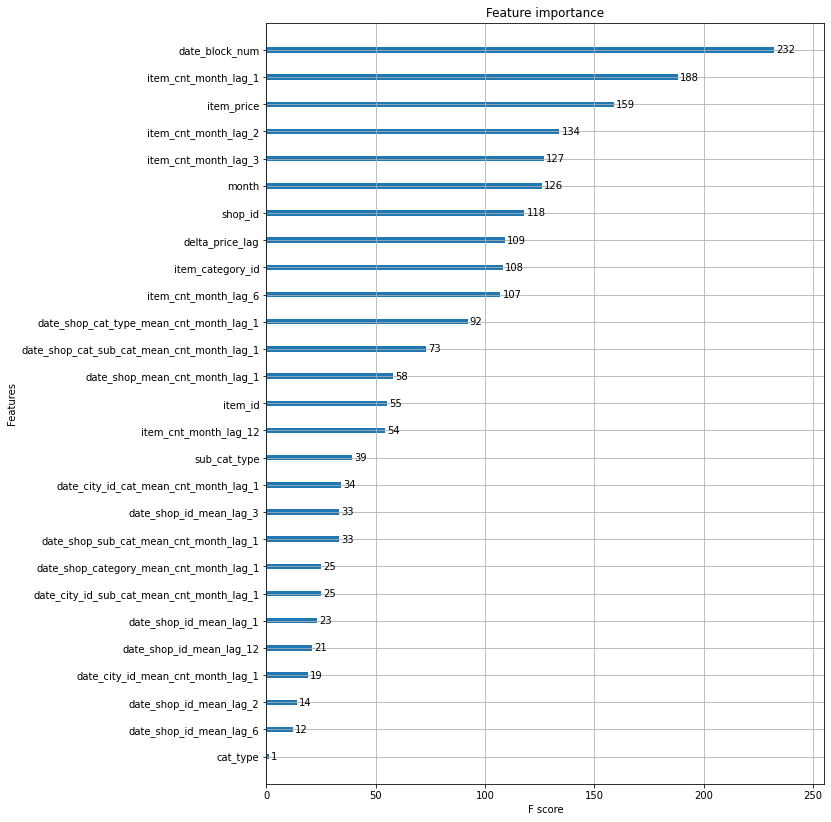

In [ ]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

In [ ]:
Y_pred = model.predict(X_test)